# Navigation tutorial

This tutorial showcases the utilities contained in the navigation subpackage of pylanetary. Learn how to use the ModelEllipsoid and Nav classes, how to find a navigation solution for observational data, how to re-project that solution to a rectilinear grid, and how to save a navigation solution to a multi-extension fits file.

In [1]:
# imports
from pylanetary.navigation import *
from pylanetary.utils import Body, convolve_with_beam
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import astropy.units as u
from astropy.io import fits

## Basic planet disk model

Compute latitude, longitude, emission angle values for an ellipsoidal planetary body on a given pixel scale and a given observation geometry using the ModelEllipsoid class.

One pixel corresponds to approximately 1.4 degrees lat/lon at the sub-observer point


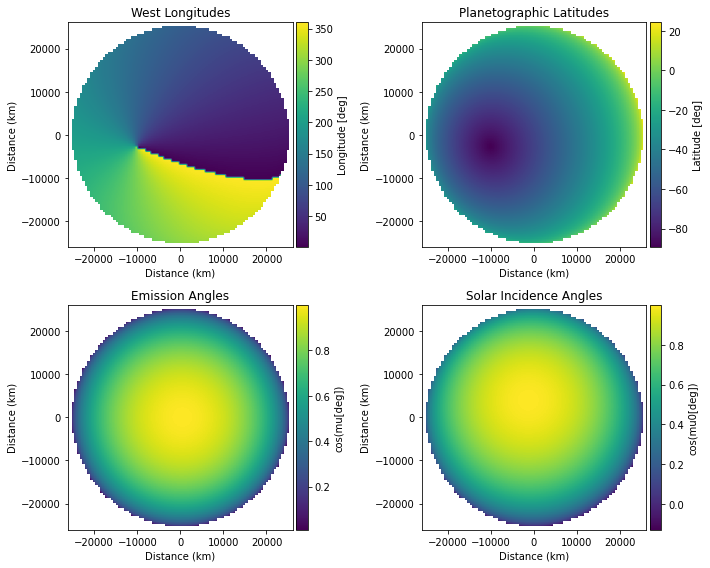

In [2]:
## user-defined inputs
ob_lon = 37.1 #degrees
ob_lat = -65 #degrees
pixscale_km = 600
np_ang = 285 #degrees
req = 25560 #km
rpol = 24970 #km
sun_lon = 60.
sun_lat = 10.

# instantiate a ModelEllipsoid
ellipsoid = ModelEllipsoid(ob_lon, ob_lat, pixscale_km, np_ang, req, rpol, sun_lon=sun_lon, sun_lat=sun_lat)

# its attributes can be called as such
shape = ellipsoid.lon_w.shape
deg_per_px = ellipsoid.deg_per_px
print(f'One pixel corresponds to approximately {deg_per_px:.1f} degrees lat/lon at the sub-observer point')

# plot it
extent = (-pixscale_km*shape[0]/2, pixscale_km*shape[0]/2, -pixscale_km*shape[1]/2, pixscale_km*shape[1]/2)
fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(2,2, figsize = (10, 8))

im0 = ax0.imshow(ellipsoid.lon_w, origin = 'lower', extent=extent)
ax0.set_title('West Longitudes')
im1 = ax1.imshow(ellipsoid.lat_g, origin = 'lower', extent=extent)
ax1.set_title('Planetographic Latitudes')
im2 = ax2.imshow(ellipsoid.mu, origin = 'lower', extent=extent)
ax2.set_title('Emission Angles')
im3 = ax3.imshow(ellipsoid.mu0, origin = 'lower', extent=extent)
ax3.set_title('Solar Incidence Angles')

ims = [im0, im1, im2, im3]
labels = ['Longitude [deg]', 'Latitude [deg]', 'cos(mu[deg])', 'cos(mu0[deg])']
for i, ax in enumerate([ax0, ax1, ax2, ax3]):
    ax.set_xlabel('Distance (km)')
    ax.set_ylabel('Distance (km)')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(ims[i], cax=cax, orientation='vertical', label=labels[i])

plt.tight_layout()
plt.show()
plt.close()

### Beam-convolved limb-darkened disk model

The ModelEllipsoid object can be leveraged to make limb-darkened or limb-brightened disk models of the planet. Several limb-darkening laws are supported - take a look at the documentation. Using the convolve_with_beam() function in utils, we can also convolve this (or anything else) with a beam. This function supports Gaussian beams or full 2-D PSFs as input; check out its docs, too!

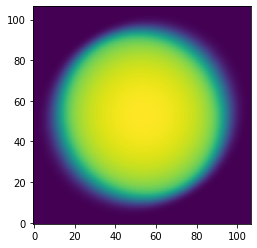

In [3]:
tb = 99.
a = [0.4, 0.1]
beam = (10., 5., 30.) #FWHM_X, FWHM_Y, THETA_DEG
lddisk = ellipsoid.ldmodel(tb, a, law='quadratic')
lddisk = convolve_with_beam(np.pad(lddisk,10), beam)
plt.imshow(lddisk, origin='lower')
plt.show()

## Model corresponding to real observations

### The ModelBody class

The ModelBody class inherits from ModelEllipsoid, so everything enabled by ModelEllipsoid above is just as easy with ModelBody. The difference is that ephemeris information is pulled from Horizons automatically for a given observation date and observatory location. Static data about the target of interest, e.g., equatorial and polar radii, are pulled from a .yaml file. See the docstring of utils.Body for more details.

Note that unlike the Nav class described below, ModelBody does not require input data, so it can be used for observation planning but is not optimal for comparing with observed data.

In [4]:
obs_time = '2019-10-28 08:50:50'
pixscale_arcsec = 0.009971 #arcsec, keck
ura = Body('Uranus', epoch=obs_time, location='568') #Maunakea keyword is 568
model = ModelBody(ura, pixscale_arcsec)

print(f'ModelBody class for target {model.name} with equatorial and polar radii {model.req, model.rpol} km')
print(f'ModelBody computed geometry on a grid of shape {model.lat_g.shape}')
print(f'Cosine of solar incidence angle at a random location is {model.mu0[240,200]:.2f}')
print(f'North polar angle w.r.t. sky North at time of observation is {model.ephem["NPole_ang"]}')
print(f'Pixel scale is {model.pixscale_km:.1f} km/px')

## save ephemeris as astropy Table for testing suite - delete later
#from astropy import io
#io.misc.hdf5.write_table_hdf5(ephem, '/Users/emolter/Python/pylanetary/pylanetary/navigation/tests/data/ephem.hdf5', 
#    serialize_meta=True,
#    overwrite=True)
#np.save('/Users/emolter/Python/pylanetary/pylanetary/navigation/tests/data/keck_uranus.npy', data)

ModelBody class for target Uranus with equatorial and polar radii (25559.0, 24973.0) km
ModelBody computed geometry on a grid of shape (377, 377)
Cosine of solar incidence angle at a random location is 0.96
North polar angle w.r.t. sky North at time of observation is 261.0522
Pixel scale is 136.2 km/px


### The Nav class

The Nav class inherits from ModelBody, so it has all the same attributes and functionality as ModelBody which, in turn, has the same attributes and functionality as ModelEllipsoid! The difference is that Nav contains additional functions to compare our models with real observed data.  Here is how to instantiate it:

In [5]:
hdul = fits.open('/Users/emolter/Python/pylanetary/notebooks/data/h_2019oct28.fits') #urh60.fits
pixscale_arcsec = 0.009971 #arcsec, keck
header = hdul[0].header
data = hdul[0].data
obs_time = header['DATE-OBS'] + ' ' + header['EXPSTART'][:-4]

ura = Body('Uranus', epoch=obs_time, location='568') #Maunakea keyword is 568
nav = Nav(data, ura, pixscale_arcsec)

Note: because ModelBody and Nav are called from a Body instance, we can easily change the default ephemeris information before instantiating them, if desired.  For example, to rotate the model so that North is up, you would do this:
```
ura = Body('Uranus', epoch=obs_time, location='568') #Keck
ura.ephem['NPole_ang'] = 0.0
nav = Nav(ura, pixscale_arcsec)
```

## Comparing models with data

Let's use our Nav object to co-locate the lat-lon grid we've computed with the observed planet itself. This is achieved with the `nav.colocate` routine. For a more detailed workflow, see the example navigation workflow documentation page.

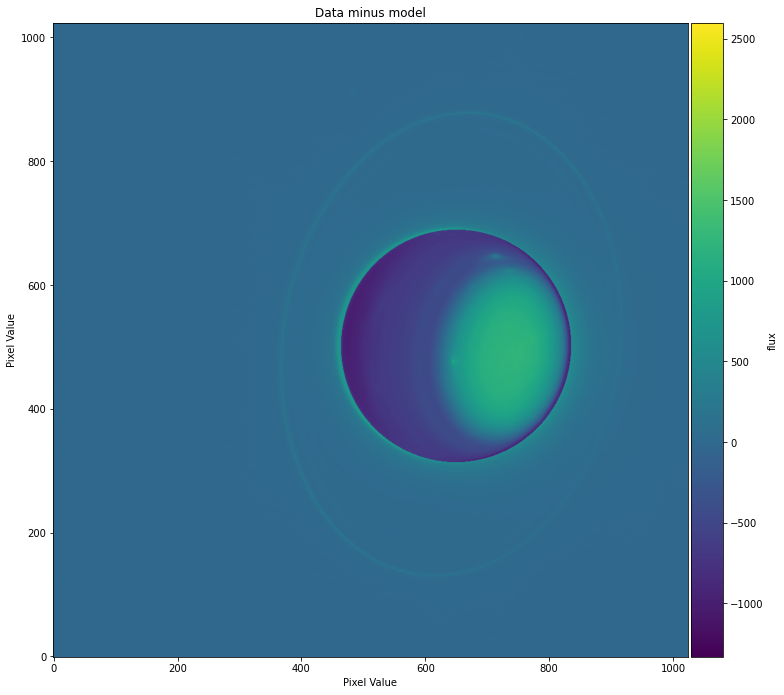

suggested x,y shift is  137.591796875 -10.681640625
x,y uncertainty is  0.005859375 0.00390625


In [6]:
# try centering using convolution with limb-darkened disk
flux = 2000 # surface brightness in whatever units are in the fits file
a = 0.1 # exponential limb-darkening law exponent
fwhm_keck = 0.5 # approximate FWHM of the point-spread function in arcsec

rms_noise = np.std(data[600:900,50:250]) * 10 #for some reason, error returns zero if true RMS is used
# wonder if this should truly be per-pixel error, or per-beam error
dx, dy, dxerr, dyerr = nav.colocate(mode='disk', tb = flux, a = a, beam = fwhm_keck, err=rms_noise)
print('suggested x,y shift is ', dx, dy)
print('x,y uncertainty is ', dxerr, dyerr)

## save ldmodel as numpy file for testing suite - delete later
#ldmodel = nav.ldmodel(flux, a, beam=fwhm_keck, law='exp')
#np.save('/Users/emolter/Python/pylanetary/pylanetary/navigation/tests/data/ldmodel.npy', ldmodel)

The diagnostic plot shows us that the model planet has been co-located with the real planet to reasonable accuracy; the disk of the planet is centered around zero, and there are no obvious positive-negative differences at the edges. There appears to be a faint halo around the planet's disk, probably due to an imperfect PSF in our model.

Nav.colocate also supports the use of an edge-detection algorithm. This is particularly useful if the planet disk is faint and the clouds are bright, e.g., for Neptune in K-band.

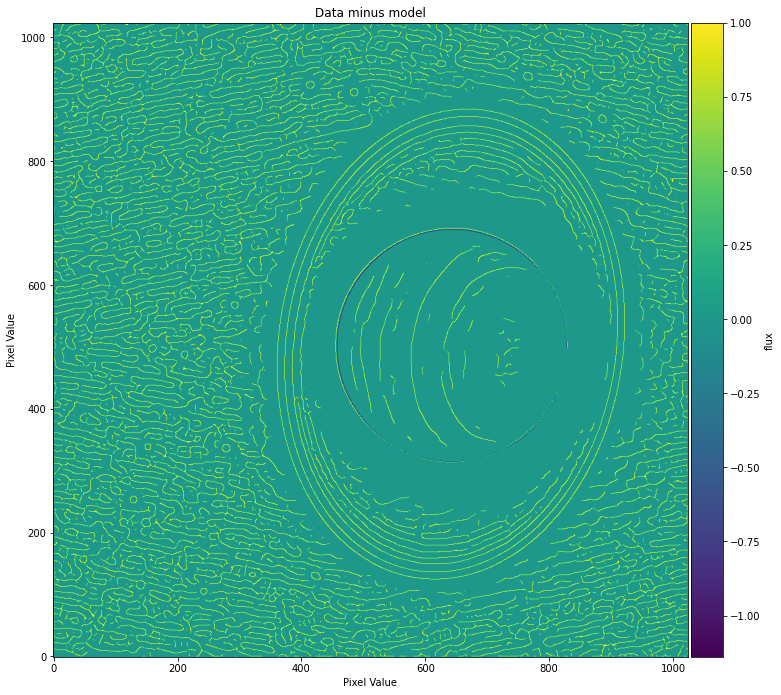

Canny x,y shift is 130.974609375 -10.126953125


In [7]:
dx_canny, dy_canny, _, _ = nav.colocate(mode='canny', tb = flux, a = a, beam = fwhm_keck, low_thresh=1e-5, high_thresh=0.01, sigma=5)
print('Canny x,y shift is', dx_canny, dy_canny)

The model edges align reasonably well with the data edges, so this looks like a somewhat reasonable solution, too. 

Note here that simply running colocate() does NOT apply the solution; that is, it does not actually shift the model such that the nav.lat_g, nav.lon_w, nav.mu, and nav.mu0 arrays align properly with the planet. This choice is intentional, as it allows the user to try co-locating with different input models and parameters until they are happy with the solution. It also means that manual x,y shifts are supported.

To apply our x,y shift if we are happy with it, we do the following:

In [8]:
nav.xy_shift_model(dx, dy)
## note: alternatively, we could center the data
# nav.xy_shift_data(-dx, -dy)

Finally, let's plot the solution:

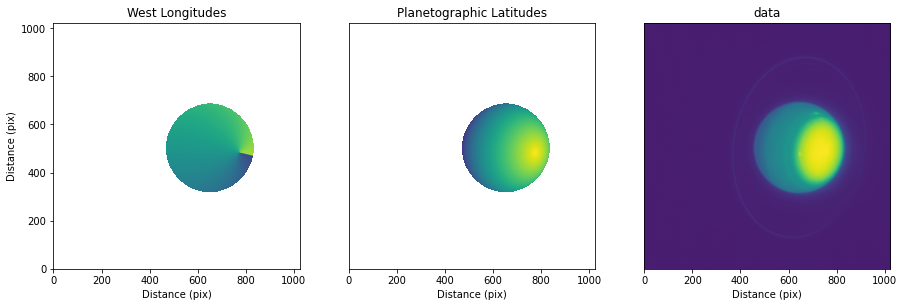

In [9]:
#extent = (-pixscale_km*shape[0]/2, pixscale_km*shape[0]/2, -pixscale_km*shape[1]/2, pixscale_km*shape[1]/2)
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize = (15, 6))

im0 = ax0.imshow(nav.lon_w, origin = 'lower')
ax0.set_title('West Longitudes')
im1 = ax1.imshow(nav.lat_g, origin = 'lower')
ax1.set_title('Planetographic Latitudes')
im2 = ax2.imshow(nav.data, origin = 'lower')
ax2.set_title('data')

ax0.set_ylabel('Distance (pix)')
ax1.set_yticks([])
ax2.set_yticks([])

for ax in [ax0, ax1, ax2]:
    ax.set_xlabel('Distance (pix)')
    ax.set_aspect('equal')

plt.show()

## save one of these as np array for testing suite - delete later
#np.save('/Users/emolter/Python/pylanetary/pylanetary/navigation/tests/data/lat_g_keck.npy', nav.lat_g)

### summary of nav.colocate methods

The following was written in support of Souami et al. 2023, in prep. If you use this for your own work, please cite the pylanetary package, and also consider citing the image\_registration and astroquery packages.

The centroid of the stacked Keck frames was found by cross-correlating the images with a limb-darkened disk model of Neptune. The model disk was assumed ellipsoidal, with equatorial and polar radii of 24764 km and 24341 km, respectively \footnote{\url{https://nssdc.gsfc.nasa.gov/planetary/factsheet/neptunefact.html}}. The model was scaled to the distance and orientation of Neptune as viewed from Keck Observatory using the JPL Horizons system, accessed using the Astropy-affiliated \texttt{astroquery} Python package. The limb darkening was applied using a Minnaert law with coefficient k = 0.867 \footnote{Wong et al 2018 value in HST blue filter; LMK if anyone finds a better value for the IR somewhere https://doi.org/10.3847/1538-3881/aaa6d6}. The model was convolved with a Gaussian beam to simulate the optics of the telescope. The FWHM of this beam was estimated based on the point-spread function of point sources in the field-of-view (e.g., Proteus). The surface brightness of the limb-darkened disk was set to be the approximate surface brightness of Neptune in cloud-free regions. Image registration between model and data was then carried out using a matrix-multiply discrete Fourier transform technique, implemented using the \texttt{chi2_shift} function within the Astropy-affiliated \texttt{image_registration} Python package \footnote{\url{https://github.com/keflavich/image_registration}}. Given the RMS noise in the image as input, this technique also yields errors in the shifts using a delta-chi-square criterion.  The values of the FWHM, model brightness, and limb-darkening parameter were varied within reasonable ranges, and the resulting x,y position was found not to change by more than 1 sigma in either direction.

## Save as fits

Pylanetary supports saving the navigation solution as a multi-extension NAV fits file, originally used by Mike Wong in IDL for data from the HST OPAL program

In [10]:
#nav.write('output.fits', header=header)

## Reproject data onto rectilinear grid

Basic support exists for projection onto a rectilinear grid, as follows

New image will be 1167 by 583 pixels
Pixel scale 136.192868 km = 3.237871 pixels per degree


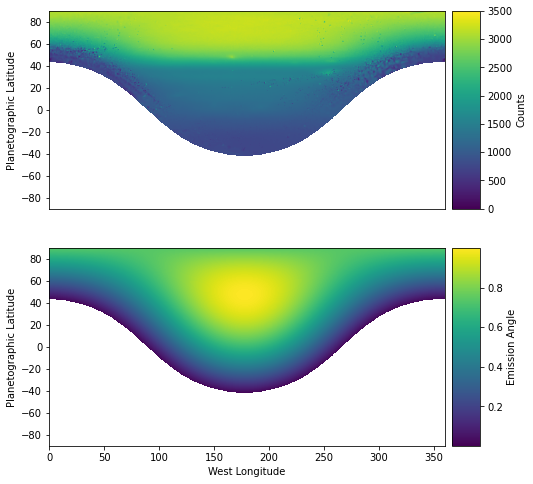

In [11]:
projected, mu_projected = nav.reproject()

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

extent = (0, 360, -90, 90)
fig, (ax0, ax1) = plt.subplots(2,1, figsize = (8,8))

im0 = ax0.imshow(projected, origin = 'lower', extent=extent, vmin=0, vmax = 3500)
ax0_divider = make_axes_locatable(ax0)
cax0 = ax0_divider.append_axes("right", size="7%", pad="2%")
cb0 = fig.colorbar(im0, cax=cax0, label='Counts')

im1 = ax1.imshow(mu_projected, origin = 'lower', extent=extent)
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cb1 = fig.colorbar(im1, cax=cax1, label='Emission Angle')

ax0.set_ylabel('Planetographic Latitude')
ax1.set_ylabel('Planetographic Latitude')
ax1.set_xlabel('West Longitude')
ax0.set_xticks([])

plt.show()

## save these as np array for testing suite - delete later
#np.save('/Users/emolter/Python/pylanetary/pylanetary/navigation/tests/data/projected.npy', projected)
#np.save('/Users/emolter/Python/pylanetary/pylanetary/navigation/tests/data/mu_projected.npy', mu_projected)

For planets with banded structure, it is easy to check the quality of the co-location based on whether or not the bands appear straight in these images. If the centroid is incorrect, then the bands are curved! 

Note here that by default, reproject() will keep the same pixel scale as the original data at the sub-observer point. This means that at every other location, the projected image is oversampled as compared with the original data. This oversampling of the original pixel grid can cause unusual-looking artifacts near the limbs of the planet. To change this default behavior, simply use: reproject(pixscale_arcsec=whatever)

We plan to support re-projection to arbitrary geometries (e.g., polar) in the near future, so stay tuned.